# Loading and pre-processing data

In [1]:
import os
from PIL import Image
import numpy as np

def load(folder_path):

    images = []

    # Iterate through all files in the folder
    for file_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, file_name)
        image = Image.open(img_path).convert("RGB")  # Ensure 3 channels (RGB)
        image = np.array(image) / 127.5 - 1.0
        images.append(image)

    images = np.array(images, dtype=np.float32)
    return images

trainA=load('/kaggle/input/horse2zebra-dataset/trainA')
trainB=load('/kaggle/input/horse2zebra-dataset/trainB')
testA=load('/kaggle/input/horse2zebra-dataset/testA')
testB=load('/kaggle/input/horse2zebra-dataset/testB')

print(trainA.shape)
print(trainB.shape)
print(testA.shape)
print(testB.shape)

(1067, 256, 256, 3)
(1334, 256, 256, 3)
(120, 256, 256, 3)
(140, 256, 256, 3)


# Generator
![](https://miro.medium.com/v2/resize:fit:1400/format:webp/0*xpzrkhjToausfj16.png)

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, ReLU, Input, Add, Activation, GroupNormalization
from tensorflow.keras.backend import clear_session

def res(inputs):
    x = Conv2D(256, (3, 3), padding='same')(inputs)
    x = GroupNormalization(groups=-1)(x)
    x = ReLU()(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = GroupNormalization(groups=-1)(x)

    return Add()([x, inputs])

def generator():
    clear_session()
    inputs = Input(shape=(256, 256, 3))

    # Initial layer
    x = Conv2D(64, (7, 7), padding='same')(inputs)
    x = GroupNormalization(groups=-1)(x)
    x = ReLU()(x)

    # Downsampling Layers
    x = Conv2D(128, (3, 3), strides=(2, 2), padding='same')(x)
    x = GroupNormalization(groups=-1)(x)
    x = ReLU()(x)

    x = Conv2D(256, (3, 3), strides=(2, 2), padding='same')(x)
    x = GroupNormalization(groups=-1)(x)
    x = ReLU()(x)

    # Residual Blocks
    for _ in range(6):
        x = res(x)

    # Upsampling Layers
    x = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(x)
    x = GroupNormalization(groups=32)(x)
    x = ReLU()(x)

    x = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(x)
    x = GroupNormalization(groups=32)(x)
    x = ReLU()(x)

    # Final Layer
    x = Conv2D(3, (7, 7), padding='same')(x)
    outputs = Activation('tanh')(x)

    return tf.keras.Model(inputs, outputs)

# Instantiate and summarize the model
generator_model = generator()
generator_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │          9,472 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ group_normalization       │ (None, 256, 256, 64)   │            128 │ conv2d[0][0]           │
│ (GroupNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 256, 256, 64)   │              0 │ group_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ re_lu[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ group_normalization_1     │ (None, 128, 128, 128)  │            256 │ conv2d_1[0][0]         │
│ (GroupNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 128, 128, 128)  │              0 │ group_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 256)    │        295,168 │ re_lu_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ group_normalization_2     │ (None, 64, 64, 256)    │            512 │ conv2d_2[0][0]         │
│ (GroupNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_2 (ReLU)            │ (None, 64, 64, 256)    │              0 │ group_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 256)    │        590,080 │ re_lu_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ group_normalization_3     │ (None, 64, 64, 256)    │            512 │ conv2d_3[0][0]         │
│ (GroupNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_3 (ReLU)            │ (None, 64, 64, 256)    │              0 │ group_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 256)    │        590,080 │ re_lu_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ group_normalization_4     │ (None, 64, 64, 256)    │            512 │ conv2d_4[0][0]         │
│ (GroupNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 64, 64, 256)    │              0 │ group_normalization_4… │
│                           │                        │                │ re_lu_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)    

 Total params: 7,845,123 (29.93 MB)

 Trainable params: 7,845,123 (29.93 MB)

 Non-trainable params: 0 (0.00 B)

# Discriminator
![](https://miro.medium.com/v2/resize:fit:1400/format:webp/0*NeVn3L3m3OfNRHXt.png)

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LeakyReLU, Conv2D, GroupNormalization
from tensorflow.keras.backend import clear_session

clear_session()

def discriminator():
    model=Sequential([
    Conv2D(64, (4,4), strides=(2, 2), padding='same', input_shape=(256,256,3)),
    GroupNormalization(groups=-1),
    LeakyReLU(),

    Conv2D(128, (4,4), strides=(2, 2), padding='same'),
    GroupNormalization(groups=-1),
    LeakyReLU(),

    Conv2D(256, (4,4), strides=(2, 2), padding='same'),
    GroupNormalization(groups=-1),
    LeakyReLU(),

    Conv2D(512, (4,4), strides=(2, 2), padding='same'),
    GroupNormalization(groups=-1),
    LeakyReLU(),

    Conv2D(1, (4,4), padding='same')
])
    return model

discriminator_model=discriminator()
discriminator_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 64)        │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ group_normalization                  │ (None, 128, 128, 64)        │             128 │
│ (GroupNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 128)         │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ group_normalization_1                │ (None, 64, 64, 128)         │             256 │
│ (GroupNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 256)         │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ group_normalization_2                │ (None, 32, 32, 256)         │             512 │
│ (GroupNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 512)         │       2,097,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ group_normalization_3                │ (None, 16, 16, 512)         │           1,024 │
│ (GroupNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 16, 16, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 16, 16, 1)           │           8,193 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,766,657 (10.55 MB)

 Trainable params: 2,766,657 (10.55 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:
loss_obj = tf.keras.losses.MeanSquaredError()

def discriminator_loss(real, fake):
    real_loss = loss_obj(tf.ones_like(real), real)
    fake_loss = loss_obj(tf.zeros_like(fake), fake)
    return (real_loss + fake_loss) * 0.5

def generator_loss(fake):
    return loss_obj(tf.ones_like(fake), fake)

def cycle_consistency_loss(real, cycled):
    return tf.reduce_mean(tf.abs(real - cycled)) * 10.0

def identity_loss(real, same):
    return tf.reduce_mean(tf.abs(real - same)) * 5.0

In [5]:
G = generator()  
F = generator()  
D_X = discriminator()  
D_Y = discriminator()  

generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# Training step
@tf.function
def train_step(real_x, real_y):
    with tf.GradientTape(persistent=True) as tape:
        # Generate fake images
        fake_y = G(real_x, training=True)
        fake_x = F(real_y, training=True)

        # Cycle consistency
        cycled_x = F(fake_y, training=True)
        cycled_y = G(fake_x, training=True)

        # Identity mapping
        same_x = F(real_x, training=True)
        same_y = G(real_y, training=True)

        # Discriminator outputs
        disc_real_x = D_X(real_x, training=True)
        disc_fake_x = D_X(fake_x, training=True)
        disc_real_y = D_Y(real_y, training=True)
        disc_fake_y = D_Y(fake_y, training=True)

        # Losses
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)
        cycle_loss = cycle_consistency_loss(real_x, cycled_x) + cycle_consistency_loss(real_y, cycled_y)
        id_loss = identity_loss(real_x, same_x) + identity_loss(real_y, same_y)

        total_gen_g_loss = gen_g_loss + cycle_loss + id_loss
        total_gen_f_loss = gen_f_loss + cycle_loss + id_loss

        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

    # Apply gradients
    generator_g_gradients = tape.gradient(total_gen_g_loss, G.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, F.trainable_variables)
    discriminator_x_gradients = tape.gradient(disc_x_loss, D_X.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, D_Y.trainable_variables)

    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, G.trainable_variables))
    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, F.trainable_variables))
    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients, D_X.trainable_variables))
    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients, D_Y.trainable_variables))

# Convert numpy arrays to tf.data.Dataset
trainA = tf.data.Dataset.from_tensor_slices(trainA).batch(1).shuffle(1000)
trainB = tf.data.Dataset.from_tensor_slices(trainB).batch(1).shuffle(1000)
testA = tf.data.Dataset.from_tensor_slices(testA).batch(1)
testB = tf.data.Dataset.from_tensor_slices(testB).batch(1)

# Training loop
EPOCHS = 50
for epoch in range(EPOCHS):
    for real_x, real_y in tf.data.Dataset.zip((trainA, trainB)):
        train_step(real_x, real_y)
    print(f"Epoch {epoch + 1}/{EPOCHS} completed.")

Epoch 1/50 completed.
Epoch 2/50 completed.
Epoch 3/50 completed.
Epoch 4/50 completed.
Epoch 5/50 completed.
Epoch 6/50 completed.
Epoch 7/50 completed.
Epoch 8/50 completed.
Epoch 9/50 completed.
Epoch 10/50 completed.
Epoch 11/50 completed.
Epoch 12/50 completed.
Epoch 13/50 completed.
Epoch 14/50 completed.
Epoch 15/50 completed.
Epoch 16/50 completed.
Epoch 17/50 completed.
Epoch 18/50 completed.
Epoch 19/50 completed.
Epoch 20/50 completed.
Epoch 21/50 completed.
Epoch 22/50 completed.
Epoch 23/50 completed.
Epoch 24/50 completed.
Epoch 25/50 completed.
Epoch 26/50 completed.
Epoch 27/50 completed.
Epoch 28/50 completed.
Epoch 29/50 completed.
Epoch 30/50 completed.
Epoch 31/50 completed.
Epoch 32/50 completed.
Epoch 33/50 completed.
Epoch 34/50 completed.
Epoch 35/50 completed.
Epoch 36/50 completed.
Epoch 37/50 completed.
Epoch 38/50 completed.
Epoch 39/50 completed.
Epoch 40/50 completed.
Epoch 41/50 completed.
Epoch 42/50 completed.
Epoch 43/50 completed.
Epoch 44/50 complete

In [6]:
G.save('G.h5')
F.save('F.h5')
D_X.save('DX.h5')
D_Y.save('DY.h5')

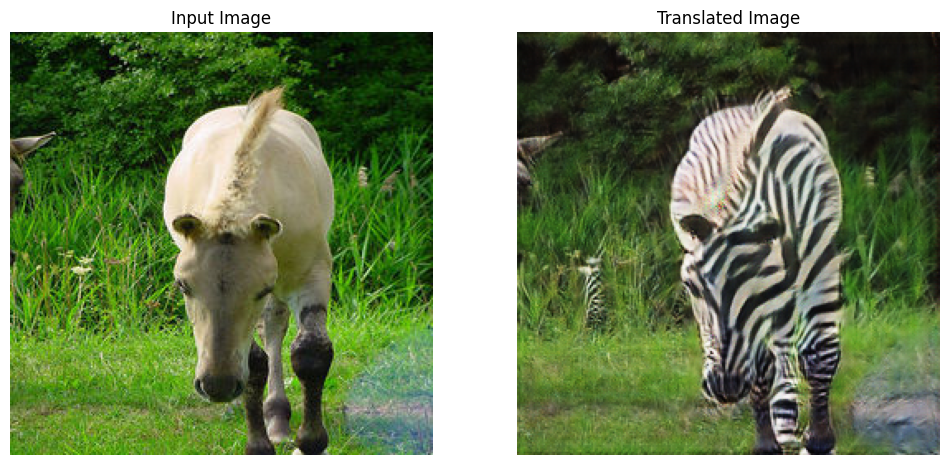

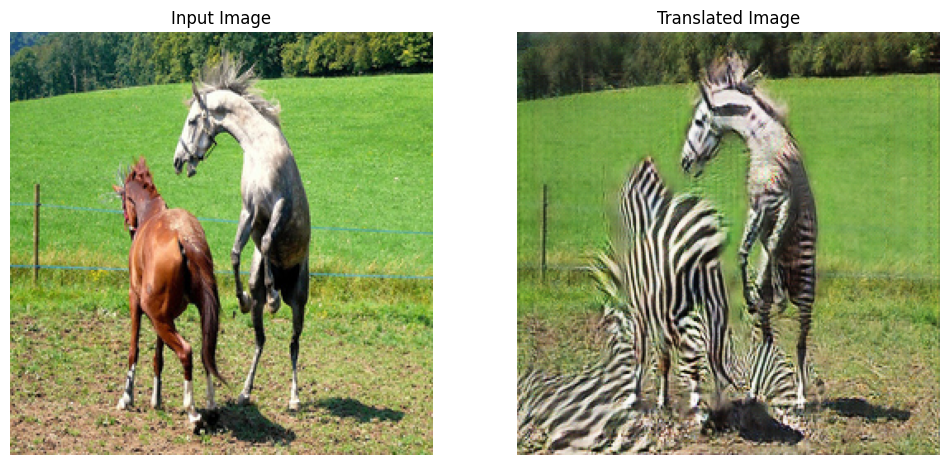

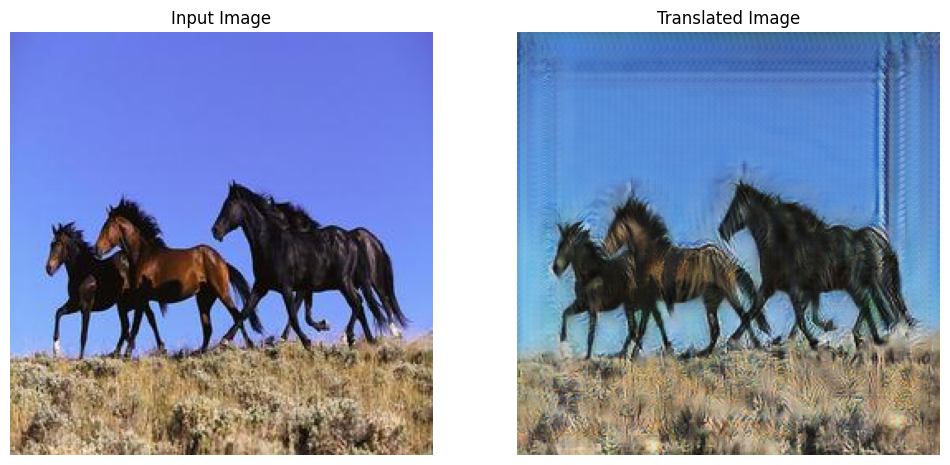

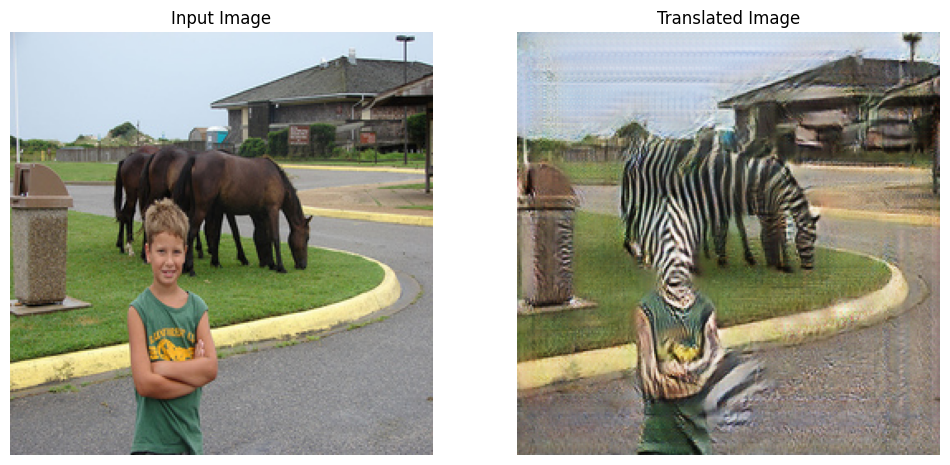

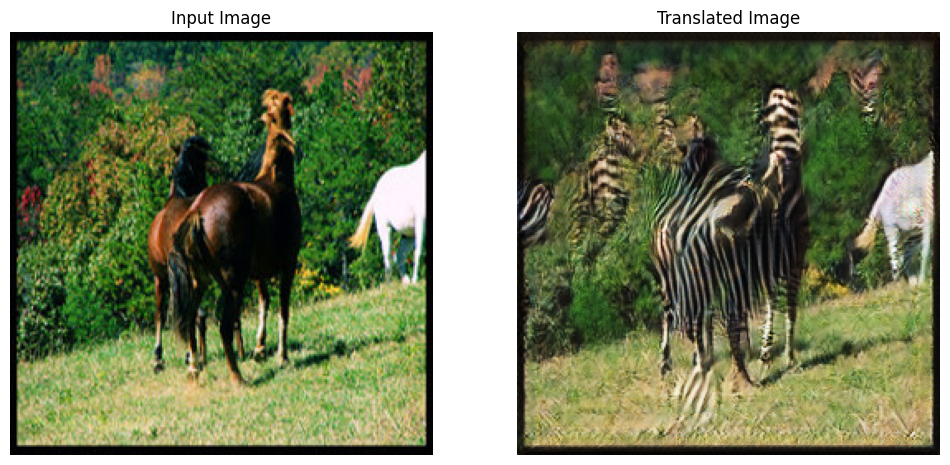

In [7]:
import matplotlib.pyplot as plt
# Test the model
def generate_images(model, test_input):
    prediction = model(test_input)
    plt.figure(figsize=(12, 12))

    display_list = [test_input[0], prediction[0]]
    titles = ['Input Image', 'Translated Image']

    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(titles[i])
        plt.imshow((display_list[i] * 0.5) + 0.5)  # Denormalize
        plt.axis('off')
    plt.show()

# Generate test results
for example_input in testA.take(5):
    generate_images(G, example_input)